In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from BaselinePrerocess import baseline_process
from baselines.cnn import cnn

2023-07-22 21:28:02.430190: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 21:28:03.874036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Preprocess

In [8]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [9]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [10]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Model

In [ ]:
# ===== model parameters ======
cnn_unit1 = 64
cnn_unit2 = 32
cnn_unit3 = 16
dropout = 0.1
kernel_size = 2
pool_size=2,
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512
input_shape = train_X_mask.shape[1:]

In [12]:
model = cnn(input_shape=input_shape,
            cnn_unit1=cnn_unit1,
            cnn_unit2=cnn_unit2,
            cnn_unit3=cnn_unit3,
            dropout=dropout,
            kernel_size=kernel_size,
            pool_size=pool_size,
            masked_value=masked_value
            )
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 16)]          0         
                                                                 
 masking_1 (Masking)         (None, 96, 16)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 96, 64)            2112      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 48, 64)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 48, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 48, 32)            4128      
                                                           

In [13]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('saved_models/cnn_gate_pump_1.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit([train_X_mask], train_ws_y,
          validation_data=([test_X_mask], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-22 21:28:25.657079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-22 21:28:26.722395: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe5f8012030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-22 21:28:26.722481: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-22 21:28:26.734356: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-22 21:28:27.112640: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.16051, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 7s - loss: 0.0661 - mae: 0.2048 - val_loss: 0.0386 - val_mae: 0.1605 - 7s/epoch - 49ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.16051 to 0.14714, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 0.0160 - mae: 0.1063 - val_loss: 0.0314 - val_mae: 0.1471 - 1s/epoch - 7ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.14714 to 0.13420, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 0.0142 - mae: 0.1006 - val_loss: 0.0262 - val_mae: 0.1342 - 1s/epoch - 7ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.13420 to 0.09630, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 0.0104 - mae: 0.0843 - val_loss: 0.0143 - val_mae: 0.0963 - 1s/epoch - 7ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.09630 to 0.07450, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 0.0052 - mae: 0.0573 - val_loss: 0.0090 - val_mae: 0.0745 - 1s/epoch - 7ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.07450 to 0.06654, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 0.0036 - mae: 0.0471 - 

Epoch 40/3000

Epoch 40: val_mae improved from 0.03258 to 0.03243, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 5.6726e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0324 - 1s/epoch - 8ms/step
Epoch 41/3000

Epoch 41: val_mae improved from 0.03243 to 0.03219, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 5.5494e-04 - mae: 0.0169 - val_loss: 0.0016 - val_mae: 0.0322 - 1s/epoch - 8ms/step
Epoch 42/3000

Epoch 42: val_mae improved from 0.03219 to 0.03185, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 5.4339e-04 - mae: 0.0166 - val_loss: 0.0015 - val_mae: 0.0318 - 1s/epoch - 8ms/step
Epoch 43/3000

Epoch 43: val_mae improved from 0.03185 to 0.03173, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 5.3313e-04 - mae: 0.0164 - val_loss: 0.0015 - val_mae: 0.0317 - 1s/epoch - 7ms/step
Epoch 44/3000

Epoch 44: val_mae improved from 0.03173 to 0.03170, saving model to saved_models/cnn_gate_pump_1.h5
151/1

Epoch 80/3000

Epoch 80: val_mae did not improve from 0.02700
151/151 - 1s - loss: 3.4117e-04 - mae: 0.0125 - val_loss: 0.0012 - val_mae: 0.0272 - 1s/epoch - 7ms/step
Epoch 81/3000

Epoch 81: val_mae did not improve from 0.02700
151/151 - 1s - loss: 3.3918e-04 - mae: 0.0124 - val_loss: 0.0012 - val_mae: 0.0270 - 1s/epoch - 7ms/step
Epoch 82/3000

Epoch 82: val_mae improved from 0.02700 to 0.02682, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 3.3660e-04 - mae: 0.0124 - val_loss: 0.0012 - val_mae: 0.0268 - 1s/epoch - 7ms/step
Epoch 83/3000

Epoch 83: val_mae improved from 0.02682 to 0.02652, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 3.3439e-04 - mae: 0.0123 - val_loss: 0.0011 - val_mae: 0.0265 - 1s/epoch - 7ms/step
Epoch 84/3000

Epoch 84: val_mae did not improve from 0.02652
151/151 - 1s - loss: 3.3199e-04 - mae: 0.0123 - val_loss: 0.0012 - val_mae: 0.0266 - 1s/epoch - 7ms/step
Epoch 85/3000

Epoch 85: val_mae did not improve from 0.026

151/151 - 1s - loss: 2.6522e-04 - mae: 0.0110 - val_loss: 0.0010 - val_mae: 0.0248 - 1s/epoch - 7ms/step
Epoch 124/3000

Epoch 124: val_mae did not improve from 0.02475
151/151 - 1s - loss: 2.6436e-04 - mae: 0.0110 - val_loss: 0.0010 - val_mae: 0.0250 - 1s/epoch - 7ms/step
Epoch 125/3000

Epoch 125: val_mae did not improve from 0.02475
151/151 - 1s - loss: 2.6349e-04 - mae: 0.0110 - val_loss: 0.0010 - val_mae: 0.0249 - 1s/epoch - 7ms/step
Epoch 126/3000

Epoch 126: val_mae did not improve from 0.02475
151/151 - 1s - loss: 2.6173e-04 - mae: 0.0109 - val_loss: 0.0010 - val_mae: 0.0248 - 1s/epoch - 7ms/step
Epoch 127/3000

Epoch 127: val_mae did not improve from 0.02475
151/151 - 1s - loss: 2.6065e-04 - mae: 0.0109 - val_loss: 0.0010 - val_mae: 0.0250 - 1s/epoch - 7ms/step
Epoch 128/3000

Epoch 128: val_mae did not improve from 0.02475
151/151 - 1s - loss: 2.5989e-04 - mae: 0.0109 - val_loss: 0.0010 - val_mae: 0.0248 - 1s/epoch - 7ms/step
Epoch 129/3000

Epoch 129: val_mae did not improve

Epoch 170/3000

Epoch 170: val_mae did not improve from 0.02434
151/151 - 1s - loss: 2.2844e-04 - mae: 0.0102 - val_loss: 9.9719e-04 - val_mae: 0.0244 - 1s/epoch - 7ms/step
Epoch 171/3000

Epoch 171: val_mae did not improve from 0.02434
151/151 - 1s - loss: 2.2765e-04 - mae: 0.0101 - val_loss: 0.0010 - val_mae: 0.0246 - 1s/epoch - 7ms/step
Epoch 172/3000

Epoch 172: val_mae did not improve from 0.02434
151/151 - 1s - loss: 2.2696e-04 - mae: 0.0101 - val_loss: 0.0010 - val_mae: 0.0245 - 1s/epoch - 7ms/step
Epoch 173/3000

Epoch 173: val_mae improved from 0.02434 to 0.02416, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 2.2674e-04 - mae: 0.0101 - val_loss: 9.7614e-04 - val_mae: 0.0242 - 1s/epoch - 7ms/step
Epoch 174/3000

Epoch 174: val_mae did not improve from 0.02416
151/151 - 1s - loss: 2.2603e-04 - mae: 0.0101 - val_loss: 9.8700e-04 - val_mae: 0.0243 - 1s/epoch - 7ms/step
Epoch 175/3000

Epoch 175: val_mae did not improve from 0.02416
151/151 - 1s - loss: 2.255

Epoch 216/3000

Epoch 216: val_mae did not improve from 0.02350
151/151 - 1s - loss: 2.0773e-04 - mae: 0.0097 - val_loss: 9.3785e-04 - val_mae: 0.0237 - 1s/epoch - 7ms/step
Epoch 217/3000

Epoch 217: val_mae did not improve from 0.02350
151/151 - 1s - loss: 2.0775e-04 - mae: 0.0096 - val_loss: 9.3134e-04 - val_mae: 0.0236 - 1s/epoch - 7ms/step
Epoch 218/3000

Epoch 218: val_mae improved from 0.02350 to 0.02335, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 2.0710e-04 - mae: 0.0096 - val_loss: 9.0783e-04 - val_mae: 0.0234 - 1s/epoch - 7ms/step
Epoch 219/3000

Epoch 219: val_mae did not improve from 0.02335
151/151 - 1s - loss: 2.0664e-04 - mae: 0.0096 - val_loss: 9.1965e-04 - val_mae: 0.0234 - 1s/epoch - 7ms/step
Epoch 220/3000

Epoch 220: val_mae did not improve from 0.02335
151/151 - 1s - loss: 2.0639e-04 - mae: 0.0096 - val_loss: 9.1932e-04 - val_mae: 0.0234 - 1s/epoch - 7ms/step
Epoch 221/3000

Epoch 221: val_mae did not improve from 0.02335
151/151 - 1s - los

Epoch 260/3000

Epoch 260: val_mae did not improve from 0.02265
151/151 - 1s - loss: 1.9353e-04 - mae: 0.0093 - val_loss: 8.8716e-04 - val_mae: 0.0230 - 1s/epoch - 7ms/step
Epoch 261/3000

Epoch 261: val_mae did not improve from 0.02265
151/151 - 1s - loss: 1.9343e-04 - mae: 0.0093 - val_loss: 8.7732e-04 - val_mae: 0.0229 - 1s/epoch - 7ms/step
Epoch 262/3000

Epoch 262: val_mae improved from 0.02265 to 0.02262, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 1.9325e-04 - mae: 0.0093 - val_loss: 8.5566e-04 - val_mae: 0.0226 - 1s/epoch - 7ms/step
Epoch 263/3000

Epoch 263: val_mae did not improve from 0.02262
151/151 - 1s - loss: 1.9278e-04 - mae: 0.0093 - val_loss: 8.6233e-04 - val_mae: 0.0227 - 1s/epoch - 7ms/step
Epoch 264/3000

Epoch 264: val_mae improved from 0.02262 to 0.02262, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 1.9264e-04 - mae: 0.0093 - val_loss: 8.5448e-04 - val_mae: 0.0226 - 1s/epoch - 7ms/step
Epoch 265/3000

Epoch 265: va

151/151 - 1s - loss: 1.8411e-04 - mae: 0.0090 - val_loss: 8.2698e-04 - val_mae: 0.0222 - 1s/epoch - 7ms/step
Epoch 305/3000

Epoch 305: val_mae did not improve from 0.02200
151/151 - 1s - loss: 1.8358e-04 - mae: 0.0090 - val_loss: 8.0851e-04 - val_mae: 0.0220 - 1s/epoch - 7ms/step
Epoch 306/3000

Epoch 306: val_mae did not improve from 0.02200
151/151 - 1s - loss: 1.8360e-04 - mae: 0.0090 - val_loss: 8.3029e-04 - val_mae: 0.0223 - 1s/epoch - 7ms/step
Epoch 307/3000

Epoch 307: val_mae did not improve from 0.02200
151/151 - 1s - loss: 1.8345e-04 - mae: 0.0090 - val_loss: 8.2266e-04 - val_mae: 0.0222 - 1s/epoch - 7ms/step
Epoch 308/3000

Epoch 308: val_mae did not improve from 0.02200
151/151 - 1s - loss: 1.8321e-04 - mae: 0.0090 - val_loss: 8.1501e-04 - val_mae: 0.0221 - 1s/epoch - 7ms/step
Epoch 309/3000

Epoch 309: val_mae did not improve from 0.02200
151/151 - 1s - loss: 1.8319e-04 - mae: 0.0090 - val_loss: 8.1994e-04 - val_mae: 0.0222 - 1s/epoch - 7ms/step
Epoch 310/3000

Epoch 310:

Epoch 350/3000

Epoch 350: val_mae improved from 0.02163 to 0.02162, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 1.7632e-04 - mae: 0.0088 - val_loss: 7.8437e-04 - val_mae: 0.0216 - 1s/epoch - 7ms/step
Epoch 351/3000

Epoch 351: val_mae did not improve from 0.02162
151/151 - 1s - loss: 1.7598e-04 - mae: 0.0088 - val_loss: 7.8675e-04 - val_mae: 0.0217 - 1s/epoch - 7ms/step
Epoch 352/3000

Epoch 352: val_mae improved from 0.02162 to 0.02153, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 1.7620e-04 - mae: 0.0088 - val_loss: 7.7888e-04 - val_mae: 0.0215 - 1s/epoch - 7ms/step
Epoch 353/3000

Epoch 353: val_mae did not improve from 0.02153
151/151 - 1s - loss: 1.7577e-04 - mae: 0.0088 - val_loss: 7.9083e-04 - val_mae: 0.0217 - 1s/epoch - 7ms/step
Epoch 354/3000

Epoch 354: val_mae did not improve from 0.02153
151/151 - 1s - loss: 1.7577e-04 - mae: 0.0088 - val_loss: 7.8540e-04 - val_mae: 0.0217 - 1s/epoch - 7ms/step
Epoch 355/3000

Epoch 355: va

Epoch 394/3000

Epoch 394: val_mae did not improve from 0.02125
151/151 - 1s - loss: 1.7040e-04 - mae: 0.0087 - val_loss: 7.7748e-04 - val_mae: 0.0215 - 1s/epoch - 7ms/step
Epoch 395/3000

Epoch 395: val_mae did not improve from 0.02125
151/151 - 1s - loss: 1.7087e-04 - mae: 0.0087 - val_loss: 7.6501e-04 - val_mae: 0.0213 - 1s/epoch - 7ms/step
Epoch 396/3000

Epoch 396: val_mae did not improve from 0.02125
151/151 - 1s - loss: 1.7032e-04 - mae: 0.0087 - val_loss: 7.8394e-04 - val_mae: 0.0216 - 1s/epoch - 7ms/step
Epoch 397/3000

Epoch 397: val_mae did not improve from 0.02125
151/151 - 1s - loss: 1.7053e-04 - mae: 0.0087 - val_loss: 7.6680e-04 - val_mae: 0.0213 - 1s/epoch - 7ms/step
Epoch 398/3000

Epoch 398: val_mae improved from 0.02125 to 0.02114, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 1.7036e-04 - mae: 0.0087 - val_loss: 7.5342e-04 - val_mae: 0.0211 - 1s/epoch - 7ms/step
Epoch 399/3000

Epoch 399: val_mae did not improve from 0.02114
151/151 - 1s - los

Epoch 440/3000

Epoch 440: val_mae did not improve from 0.02100
151/151 - 1s - loss: 1.6617e-04 - mae: 0.0085 - val_loss: 7.5726e-04 - val_mae: 0.0212 - 1s/epoch - 7ms/step
Epoch 441/3000

Epoch 441: val_mae did not improve from 0.02100
151/151 - 1s - loss: 1.6585e-04 - mae: 0.0085 - val_loss: 7.6791e-04 - val_mae: 0.0213 - 991ms/epoch - 7ms/step
Epoch 442/3000

Epoch 442: val_mae did not improve from 0.02100
151/151 - 1s - loss: 1.6573e-04 - mae: 0.0085 - val_loss: 7.5492e-04 - val_mae: 0.0212 - 1s/epoch - 7ms/step
Epoch 443/3000

Epoch 443: val_mae did not improve from 0.02100
151/151 - 1s - loss: 1.6564e-04 - mae: 0.0085 - val_loss: 7.5883e-04 - val_mae: 0.0212 - 1s/epoch - 7ms/step
Epoch 444/3000

Epoch 444: val_mae did not improve from 0.02100
151/151 - 1s - loss: 1.6560e-04 - mae: 0.0085 - val_loss: 7.6468e-04 - val_mae: 0.0213 - 1s/epoch - 7ms/step
Epoch 445/3000

Epoch 445: val_mae did not improve from 0.02100
151/151 - 1s - loss: 1.6546e-04 - mae: 0.0085 - val_loss: 7.7528e-04

151/151 - 1s - loss: 1.6223e-04 - mae: 0.0084 - val_loss: 7.5158e-04 - val_mae: 0.0211 - 1s/epoch - 7ms/step
Epoch 487/3000

Epoch 487: val_mae did not improve from 0.02087
151/151 - 1s - loss: 1.6170e-04 - mae: 0.0084 - val_loss: 7.6058e-04 - val_mae: 0.0212 - 990ms/epoch - 7ms/step
Epoch 488/3000

Epoch 488: val_mae did not improve from 0.02087
151/151 - 1s - loss: 1.6212e-04 - mae: 0.0084 - val_loss: 7.4945e-04 - val_mae: 0.0210 - 977ms/epoch - 6ms/step
Epoch 489/3000

Epoch 489: val_mae did not improve from 0.02087
151/151 - 1s - loss: 1.6196e-04 - mae: 0.0084 - val_loss: 7.4190e-04 - val_mae: 0.0209 - 1s/epoch - 7ms/step
Epoch 490/3000

Epoch 490: val_mae did not improve from 0.02087
151/151 - 1s - loss: 1.6175e-04 - mae: 0.0084 - val_loss: 7.5864e-04 - val_mae: 0.0212 - 1s/epoch - 7ms/step
Epoch 491/3000

Epoch 491: val_mae did not improve from 0.02087
151/151 - 1s - loss: 1.6161e-04 - mae: 0.0084 - val_loss: 7.5292e-04 - val_mae: 0.0211 - 1s/epoch - 7ms/step
Epoch 492/3000

Epoc

Epoch 533/3000

Epoch 533: val_mae did not improve from 0.02078
151/151 - 1s - loss: 1.5883e-04 - mae: 0.0083 - val_loss: 7.6276e-04 - val_mae: 0.0211 - 1s/epoch - 7ms/step
Epoch 534/3000

Epoch 534: val_mae improved from 0.02078 to 0.02077, saving model to saved_models/cnn_gate_pump_1.h5
151/151 - 1s - loss: 1.5849e-04 - mae: 0.0083 - val_loss: 7.3843e-04 - val_mae: 0.0208 - 1s/epoch - 7ms/step
Epoch 535/3000

Epoch 535: val_mae did not improve from 0.02077
151/151 - 1s - loss: 1.5860e-04 - mae: 0.0083 - val_loss: 7.5437e-04 - val_mae: 0.0210 - 1s/epoch - 7ms/step
Epoch 536/3000

Epoch 536: val_mae did not improve from 0.02077
151/151 - 1s - loss: 1.5852e-04 - mae: 0.0083 - val_loss: 7.6486e-04 - val_mae: 0.0212 - 1s/epoch - 7ms/step
Epoch 537/3000

Epoch 537: val_mae did not improve from 0.02077
151/151 - 1s - loss: 1.5848e-04 - mae: 0.0083 - val_loss: 7.4820e-04 - val_mae: 0.0210 - 1s/epoch - 7ms/step
Epoch 538/3000

Epoch 538: val_mae did not improve from 0.02077
151/151 - 1s - los

Epoch 580/3000

Epoch 580: val_mae did not improve from 0.02067
151/151 - 1s - loss: 1.5605e-04 - mae: 0.0082 - val_loss: 7.5023e-04 - val_mae: 0.0209 - 1s/epoch - 7ms/step
Epoch 581/3000

Epoch 581: val_mae did not improve from 0.02067
151/151 - 1s - loss: 1.5617e-04 - mae: 0.0082 - val_loss: 7.5874e-04 - val_mae: 0.0211 - 990ms/epoch - 7ms/step
Epoch 582/3000

Epoch 582: val_mae did not improve from 0.02067
151/151 - 1s - loss: 1.5574e-04 - mae: 0.0082 - val_loss: 7.5313e-04 - val_mae: 0.0210 - 982ms/epoch - 7ms/step
Epoch 583/3000

Epoch 583: val_mae did not improve from 0.02067
151/151 - 1s - loss: 1.5606e-04 - mae: 0.0082 - val_loss: 7.4918e-04 - val_mae: 0.0209 - 987ms/epoch - 7ms/step
Epoch 584/3000

Epoch 584: val_mae did not improve from 0.02067
151/151 - 1s - loss: 1.5550e-04 - mae: 0.0082 - val_loss: 7.4489e-04 - val_mae: 0.0208 - 1s/epoch - 7ms/step
Epoch 585/3000

Epoch 585: val_mae did not improve from 0.02067
151/151 - 1s - loss: 1.5607e-04 - mae: 0.0082 - val_loss: 7.42

Epoch 627/3000

Epoch 627: val_mae did not improve from 0.02062
151/151 - 1s - loss: 1.5371e-04 - mae: 0.0082 - val_loss: 7.4238e-04 - val_mae: 0.0208 - 1s/epoch - 7ms/step
Epoch 628/3000

Epoch 628: val_mae did not improve from 0.02062
151/151 - 1s - loss: 1.5352e-04 - mae: 0.0082 - val_loss: 7.5193e-04 - val_mae: 0.0209 - 1s/epoch - 7ms/step
Epoch 629/3000

Epoch 629: val_mae did not improve from 0.02062
151/151 - 1s - loss: 1.5343e-04 - mae: 0.0082 - val_loss: 7.5305e-04 - val_mae: 0.0209 - 980ms/epoch - 6ms/step
Epoch 630/3000

Epoch 630: val_mae did not improve from 0.02062
151/151 - 1s - loss: 1.5339e-04 - mae: 0.0082 - val_loss: 7.4232e-04 - val_mae: 0.0208 - 960ms/epoch - 6ms/step
Epoch 631/3000

Epoch 631: val_mae did not improve from 0.02062
151/151 - 1s - loss: 1.5333e-04 - mae: 0.0081 - val_loss: 7.4379e-04 - val_mae: 0.0208 - 973ms/epoch - 6ms/step
Epoch 632/3000

Epoch 632: val_mae did not improve from 0.02062
151/151 - 1s - loss: 1.5324e-04 - mae: 0.0081 - val_loss: 7.50

Epoch 674/3000

Epoch 674: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.5150e-04 - mae: 0.0081 - val_loss: 7.3680e-04 - val_mae: 0.0207 - 985ms/epoch - 7ms/step
Epoch 675/3000

Epoch 675: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.5127e-04 - mae: 0.0081 - val_loss: 7.4214e-04 - val_mae: 0.0207 - 1s/epoch - 7ms/step
Epoch 676/3000

Epoch 676: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.5171e-04 - mae: 0.0081 - val_loss: 7.3719e-04 - val_mae: 0.0206 - 991ms/epoch - 7ms/step
Epoch 677/3000

Epoch 677: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.5131e-04 - mae: 0.0081 - val_loss: 7.5323e-04 - val_mae: 0.0209 - 958ms/epoch - 6ms/step
Epoch 678/3000

Epoch 678: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.5129e-04 - mae: 0.0081 - val_loss: 7.4775e-04 - val_mae: 0.0208 - 964ms/epoch - 6ms/step
Epoch 679/3000

Epoch 679: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.5107e-04 - mae: 0.0081 - val_loss: 7


Epoch 721: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.4972e-04 - mae: 0.0080 - val_loss: 7.5129e-04 - val_mae: 0.0208 - 999ms/epoch - 7ms/step
Epoch 722/3000

Epoch 722: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.4967e-04 - mae: 0.0080 - val_loss: 7.3363e-04 - val_mae: 0.0206 - 985ms/epoch - 7ms/step
Epoch 723/3000

Epoch 723: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.4945e-04 - mae: 0.0080 - val_loss: 7.3861e-04 - val_mae: 0.0206 - 1s/epoch - 7ms/step
Epoch 724/3000

Epoch 724: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.4947e-04 - mae: 0.0080 - val_loss: 7.4110e-04 - val_mae: 0.0207 - 986ms/epoch - 7ms/step
Epoch 725/3000

Epoch 725: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.4944e-04 - mae: 0.0080 - val_loss: 7.4124e-04 - val_mae: 0.0207 - 996ms/epoch - 7ms/step
Epoch 726/3000

Epoch 726: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.4946e-04 - mae: 0.0080 - val_loss: 7.3390e-04 - val

151/151 - 1s - loss: 1.4813e-04 - mae: 0.0080 - val_loss: 7.4554e-04 - val_mae: 0.0207 - 990ms/epoch - 7ms/step
Epoch 769/3000

Epoch 769: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.4807e-04 - mae: 0.0080 - val_loss: 7.3105e-04 - val_mae: 0.0205 - 1s/epoch - 7ms/step
Epoch 770/3000

Epoch 770: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.4772e-04 - mae: 0.0080 - val_loss: 7.3984e-04 - val_mae: 0.0206 - 1s/epoch - 7ms/step
Epoch 771/3000

Epoch 771: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.4771e-04 - mae: 0.0080 - val_loss: 7.4338e-04 - val_mae: 0.0207 - 992ms/epoch - 7ms/step
Epoch 772/3000

Epoch 772: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.4785e-04 - mae: 0.0080 - val_loss: 7.4404e-04 - val_mae: 0.0207 - 968ms/epoch - 6ms/step
Epoch 773/3000

Epoch 773: val_mae did not improve from 0.02046
151/151 - 1s - loss: 1.4782e-04 - mae: 0.0080 - val_loss: 7.4687e-04 - val_mae: 0.0207 - 982ms/epoch - 7ms/step
Epoch 774/3000

Epoch 815/3000

Epoch 815: val_mae did not improve from 0.02034
151/151 - 1s - loss: 1.4641e-04 - mae: 0.0079 - val_loss: 7.3067e-04 - val_mae: 0.0204 - 992ms/epoch - 7ms/step
Epoch 816/3000

Epoch 816: val_mae did not improve from 0.02034
151/151 - 1s - loss: 1.4623e-04 - mae: 0.0079 - val_loss: 7.2694e-04 - val_mae: 0.0205 - 993ms/epoch - 7ms/step
Epoch 817/3000

Epoch 817: val_mae did not improve from 0.02034
151/151 - 1s - loss: 1.4640e-04 - mae: 0.0079 - val_loss: 7.2670e-04 - val_mae: 0.0204 - 1s/epoch - 7ms/step
Epoch 818/3000

Epoch 818: val_mae did not improve from 0.02034
151/151 - 1s - loss: 1.4638e-04 - mae: 0.0079 - val_loss: 7.2865e-04 - val_mae: 0.0204 - 1s/epoch - 7ms/step
Epoch 819/3000

Epoch 819: val_mae did not improve from 0.02034
151/151 - 1s - loss: 1.4632e-04 - mae: 0.0079 - val_loss: 7.3578e-04 - val_mae: 0.0205 - 1000ms/epoch - 7ms/step
Epoch 820/3000

Epoch 820: val_mae did not improve from 0.02034
151/151 - 1s - loss: 1.4628e-04 - mae: 0.0079 - val_loss: 7.2

Epoch 861/3000

Epoch 861: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4489e-04 - mae: 0.0079 - val_loss: 7.3134e-04 - val_mae: 0.0204 - 1s/epoch - 7ms/step
Epoch 862/3000

Epoch 862: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4517e-04 - mae: 0.0079 - val_loss: 7.2042e-04 - val_mae: 0.0203 - 1s/epoch - 7ms/step
Epoch 863/3000

Epoch 863: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4507e-04 - mae: 0.0079 - val_loss: 7.1823e-04 - val_mae: 0.0203 - 1s/epoch - 7ms/step
Epoch 864/3000

Epoch 864: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4484e-04 - mae: 0.0079 - val_loss: 7.5184e-04 - val_mae: 0.0208 - 1s/epoch - 7ms/step
Epoch 865/3000

Epoch 865: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4498e-04 - mae: 0.0079 - val_loss: 7.2743e-04 - val_mae: 0.0204 - 1s/epoch - 7ms/step
Epoch 866/3000

Epoch 866: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4465e-04 - mae: 0.0079 - val_loss: 7.4337e-04 - 


Epoch 908: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4369e-04 - mae: 0.0078 - val_loss: 7.3190e-04 - val_mae: 0.0204 - 1s/epoch - 7ms/step
Epoch 909/3000

Epoch 909: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4401e-04 - mae: 0.0079 - val_loss: 7.2202e-04 - val_mae: 0.0203 - 1s/epoch - 7ms/step
Epoch 910/3000

Epoch 910: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4360e-04 - mae: 0.0078 - val_loss: 7.2529e-04 - val_mae: 0.0204 - 987ms/epoch - 7ms/step
Epoch 911/3000

Epoch 911: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4381e-04 - mae: 0.0079 - val_loss: 7.1375e-04 - val_mae: 0.0202 - 1s/epoch - 7ms/step
Epoch 912/3000

Epoch 912: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4362e-04 - mae: 0.0078 - val_loss: 7.1887e-04 - val_mae: 0.0203 - 1s/epoch - 7ms/step
Epoch 913/3000

Epoch 913: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4361e-04 - mae: 0.0078 - val_loss: 7.1628e-04 - val_mae: 0.0

151/151 - 1s - loss: 1.4279e-04 - mae: 0.0078 - val_loss: 7.3015e-04 - val_mae: 0.0205 - 987ms/epoch - 7ms/step
Epoch 956/3000

Epoch 956: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4266e-04 - mae: 0.0078 - val_loss: 7.3092e-04 - val_mae: 0.0204 - 1s/epoch - 7ms/step
Epoch 957/3000

Epoch 957: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4256e-04 - mae: 0.0078 - val_loss: 7.2427e-04 - val_mae: 0.0204 - 1s/epoch - 7ms/step
Epoch 958/3000

Epoch 958: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4235e-04 - mae: 0.0078 - val_loss: 7.1827e-04 - val_mae: 0.0203 - 1s/epoch - 7ms/step
Epoch 959/3000

Epoch 959: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4270e-04 - mae: 0.0078 - val_loss: 7.2661e-04 - val_mae: 0.0204 - 1s/epoch - 7ms/step
Epoch 960/3000

Epoch 960: val_mae did not improve from 0.02014
151/151 - 1s - loss: 1.4276e-04 - mae: 0.0078 - val_loss: 7.2071e-04 - val_mae: 0.0203 - 1s/epoch - 7ms/step
Epoch 961/3000

Epoch 9

Epoch 1002/3000

Epoch 1002: val_mae did not improve from 0.02002
151/151 - 1s - loss: 1.4174e-04 - mae: 0.0078 - val_loss: 7.0999e-04 - val_mae: 0.0202 - 994ms/epoch - 7ms/step
Epoch 1003/3000

Epoch 1003: val_mae did not improve from 0.02002
151/151 - 1s - loss: 1.4130e-04 - mae: 0.0078 - val_loss: 7.3475e-04 - val_mae: 0.0205 - 1s/epoch - 7ms/step
Epoch 1004/3000

Epoch 1004: val_mae did not improve from 0.02002
151/151 - 1s - loss: 1.4152e-04 - mae: 0.0078 - val_loss: 7.0479e-04 - val_mae: 0.0200 - 992ms/epoch - 7ms/step
Epoch 1005/3000

Epoch 1005: val_mae did not improve from 0.02002
151/151 - 1s - loss: 1.4140e-04 - mae: 0.0078 - val_loss: 7.0968e-04 - val_mae: 0.0201 - 981ms/epoch - 6ms/step
Epoch 1006/3000

Epoch 1006: val_mae did not improve from 0.02002
151/151 - 1s - loss: 1.4127e-04 - mae: 0.0078 - val_loss: 7.1401e-04 - val_mae: 0.0202 - 974ms/epoch - 6ms/step
Epoch 1007/3000

Epoch 1007: val_mae did not improve from 0.02002
151/151 - 1s - loss: 1.4154e-04 - mae: 0.0078 -

Epoch 1048/3000

Epoch 1048: val_mae did not improve from 0.01992
151/151 - 1s - loss: 1.4053e-04 - mae: 0.0077 - val_loss: 7.1272e-04 - val_mae: 0.0202 - 1s/epoch - 7ms/step
Epoch 1049/3000

Epoch 1049: val_mae did not improve from 0.01992
151/151 - 1s - loss: 1.4057e-04 - mae: 0.0078 - val_loss: 7.1449e-04 - val_mae: 0.0202 - 1s/epoch - 7ms/step
Epoch 1050/3000

Epoch 1050: val_mae did not improve from 0.01992
151/151 - 1s - loss: 1.4052e-04 - mae: 0.0077 - val_loss: 7.2365e-04 - val_mae: 0.0203 - 988ms/epoch - 7ms/step
Epoch 1051/3000

Epoch 1051: val_mae did not improve from 0.01992
151/151 - 1s - loss: 1.4067e-04 - mae: 0.0077 - val_loss: 7.2289e-04 - val_mae: 0.0203 - 1s/epoch - 7ms/step
Epoch 1052/3000

Epoch 1052: val_mae did not improve from 0.01992
151/151 - 1s - loss: 1.4071e-04 - mae: 0.0077 - val_loss: 7.0484e-04 - val_mae: 0.0201 - 998ms/epoch - 7ms/step
Epoch 1053/3000

Epoch 1053: val_mae did not improve from 0.01992
151/151 - 1s - loss: 1.4047e-04 - mae: 0.0077 - val_l

Epoch 1095/3000

Epoch 1095: val_mae did not improve from 0.01992
151/151 - 1s - loss: 1.3996e-04 - mae: 0.0077 - val_loss: 7.1380e-04 - val_mae: 0.0201 - 1s/epoch - 7ms/step
Epoch 1096/3000

Epoch 1096: val_mae did not improve from 0.01992
151/151 - 1s - loss: 1.3950e-04 - mae: 0.0077 - val_loss: 7.1075e-04 - val_mae: 0.0201 - 1s/epoch - 7ms/step
Epoch 1097/3000

Epoch 1097: val_mae did not improve from 0.01992
151/151 - 1s - loss: 1.3965e-04 - mae: 0.0077 - val_loss: 7.2955e-04 - val_mae: 0.0204 - 983ms/epoch - 7ms/step
Epoch 1098/3000

Epoch 1098: val_mae did not improve from 0.01992
151/151 - 1s - loss: 1.3977e-04 - mae: 0.0077 - val_loss: 7.1807e-04 - val_mae: 0.0202 - 996ms/epoch - 7ms/step
Epoch 1099/3000

Epoch 1099: val_mae did not improve from 0.01992
151/151 - 1s - loss: 1.3947e-04 - mae: 0.0077 - val_loss: 7.0798e-04 - val_mae: 0.0201 - 1s/epoch - 7ms/step
Epoch 1100/3000

Epoch 1100: val_mae did not improve from 0.01992
151/151 - 1s - loss: 1.3960e-04 - mae: 0.0077 - val_l

151/151 - 1s - loss: 1.3888e-04 - mae: 0.0077 - val_loss: 7.1188e-04 - val_mae: 0.0201 - 1s/epoch - 7ms/step
Epoch 1142/3000

Epoch 1142: val_mae did not improve from 0.01991
151/151 - 1s - loss: 1.3897e-04 - mae: 0.0077 - val_loss: 7.0531e-04 - val_mae: 0.0200 - 1s/epoch - 7ms/step
Epoch 1143/3000

Epoch 1143: val_mae did not improve from 0.01991
151/151 - 1s - loss: 1.3876e-04 - mae: 0.0077 - val_loss: 7.0212e-04 - val_mae: 0.0200 - 984ms/epoch - 7ms/step
Epoch 1144/3000

Epoch 1144: val_mae did not improve from 0.01991
151/151 - 1s - loss: 1.3882e-04 - mae: 0.0077 - val_loss: 7.0058e-04 - val_mae: 0.0200 - 1s/epoch - 7ms/step
Epoch 1145/3000

Epoch 1145: val_mae did not improve from 0.01991
151/151 - 1s - loss: 1.3889e-04 - mae: 0.0077 - val_loss: 7.0842e-04 - val_mae: 0.0201 - 991ms/epoch - 7ms/step
Epoch 1146/3000

Epoch 1146: val_mae did not improve from 0.01991
151/151 - 1s - loss: 1.3904e-04 - mae: 0.0077 - val_loss: 7.1040e-04 - val_mae: 0.0201 - 1s/epoch - 7ms/step
Epoch 1147


Epoch 1188: val_mae did not improve from 0.01991
151/151 - 1s - loss: 1.3814e-04 - mae: 0.0077 - val_loss: 7.0665e-04 - val_mae: 0.0201 - 1s/epoch - 7ms/step
Epoch 1189/3000

Epoch 1189: val_mae did not improve from 0.01991
151/151 - 1s - loss: 1.3815e-04 - mae: 0.0077 - val_loss: 7.1737e-04 - val_mae: 0.0202 - 1s/epoch - 7ms/step
Epoch 1190/3000

Epoch 1190: val_mae did not improve from 0.01991
151/151 - 1s - loss: 1.3814e-04 - mae: 0.0077 - val_loss: 7.1152e-04 - val_mae: 0.0202 - 1s/epoch - 7ms/step
Epoch 1191/3000

Epoch 1191: val_mae did not improve from 0.01991
151/151 - 1s - loss: 1.3826e-04 - mae: 0.0077 - val_loss: 7.2629e-04 - val_mae: 0.0204 - 987ms/epoch - 7ms/step
Epoch 1192/3000

Epoch 1192: val_mae did not improve from 0.01991
151/151 - 1s - loss: 1.3815e-04 - mae: 0.0077 - val_loss: 7.0519e-04 - val_mae: 0.0200 - 999ms/epoch - 7ms/step
Epoch 1193/3000

Epoch 1193: val_mae did not improve from 0.01991
151/151 - 1s - loss: 1.3815e-04 - mae: 0.0077 - val_loss: 7.0906e-04 

151/151 - 1s - loss: 1.3745e-04 - mae: 0.0076 - val_loss: 7.1254e-04 - val_mae: 0.0202 - 1s/epoch - 7ms/step
Epoch 1235/3000

Epoch 1235: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3739e-04 - mae: 0.0076 - val_loss: 7.1714e-04 - val_mae: 0.0202 - 1s/epoch - 7ms/step
Epoch 1236/3000

Epoch 1236: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3762e-04 - mae: 0.0076 - val_loss: 7.0600e-04 - val_mae: 0.0200 - 1s/epoch - 7ms/step
Epoch 1237/3000

Epoch 1237: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3750e-04 - mae: 0.0076 - val_loss: 7.1019e-04 - val_mae: 0.0201 - 1s/epoch - 7ms/step
Epoch 1238/3000

Epoch 1238: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3745e-04 - mae: 0.0076 - val_loss: 7.1839e-04 - val_mae: 0.0202 - 981ms/epoch - 6ms/step
Epoch 1239/3000

Epoch 1239: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3750e-04 - mae: 0.0076 - val_loss: 7.0703e-04 - val_mae: 0.0201 - 984ms/epoch - 7ms/step
Epoch 1240

Epoch 1281/3000

Epoch 1281: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3668e-04 - mae: 0.0076 - val_loss: 7.2196e-04 - val_mae: 0.0203 - 1s/epoch - 7ms/step
Epoch 1282/3000

Epoch 1282: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3679e-04 - mae: 0.0076 - val_loss: 7.1071e-04 - val_mae: 0.0201 - 999ms/epoch - 7ms/step
Epoch 1283/3000

Epoch 1283: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3676e-04 - mae: 0.0076 - val_loss: 6.9950e-04 - val_mae: 0.0200 - 1s/epoch - 7ms/step
Epoch 1284/3000

Epoch 1284: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3705e-04 - mae: 0.0076 - val_loss: 7.0270e-04 - val_mae: 0.0200 - 1s/epoch - 7ms/step
Epoch 1285/3000

Epoch 1285: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3680e-04 - mae: 0.0076 - val_loss: 7.2011e-04 - val_mae: 0.0203 - 1s/epoch - 7ms/step
Epoch 1286/3000

Epoch 1286: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3673e-04 - mae: 0.0076 - val_loss

Epoch 1328/3000

Epoch 1328: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3643e-04 - mae: 0.0076 - val_loss: 7.1871e-04 - val_mae: 0.0202 - 1s/epoch - 7ms/step
Epoch 1329/3000

Epoch 1329: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3632e-04 - mae: 0.0076 - val_loss: 7.1174e-04 - val_mae: 0.0201 - 1s/epoch - 7ms/step
Epoch 1330/3000

Epoch 1330: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3610e-04 - mae: 0.0076 - val_loss: 7.1924e-04 - val_mae: 0.0203 - 1s/epoch - 7ms/step
Epoch 1331/3000

Epoch 1331: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3623e-04 - mae: 0.0076 - val_loss: 7.2069e-04 - val_mae: 0.0203 - 998ms/epoch - 7ms/step
Epoch 1332/3000

Epoch 1332: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3641e-04 - mae: 0.0076 - val_loss: 7.0425e-04 - val_mae: 0.0200 - 1s/epoch - 7ms/step
Epoch 1333/3000

Epoch 1333: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3642e-04 - mae: 0.0076 - val_loss

Epoch 1375/3000

Epoch 1375: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3574e-04 - mae: 0.0076 - val_loss: 7.1609e-04 - val_mae: 0.0202 - 1s/epoch - 7ms/step
Epoch 1376/3000

Epoch 1376: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3560e-04 - mae: 0.0076 - val_loss: 7.1622e-04 - val_mae: 0.0202 - 1s/epoch - 7ms/step
Epoch 1377/3000

Epoch 1377: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3566e-04 - mae: 0.0076 - val_loss: 7.2442e-04 - val_mae: 0.0204 - 988ms/epoch - 7ms/step
Epoch 1378/3000

Epoch 1378: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3580e-04 - mae: 0.0076 - val_loss: 7.1526e-04 - val_mae: 0.0202 - 997ms/epoch - 7ms/step
Epoch 1379/3000

Epoch 1379: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3547e-04 - mae: 0.0076 - val_loss: 7.2087e-04 - val_mae: 0.0204 - 1s/epoch - 7ms/step
Epoch 1380/3000

Epoch 1380: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3552e-04 - mae: 0.0076 - val_l

Epoch 1422/3000

Epoch 1422: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3519e-04 - mae: 0.0076 - val_loss: 7.2426e-04 - val_mae: 0.0204 - 977ms/epoch - 6ms/step
Epoch 1423/3000

Epoch 1423: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3503e-04 - mae: 0.0076 - val_loss: 7.2604e-04 - val_mae: 0.0204 - 998ms/epoch - 7ms/step
Epoch 1424/3000

Epoch 1424: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3519e-04 - mae: 0.0076 - val_loss: 7.1892e-04 - val_mae: 0.0202 - 1s/epoch - 7ms/step
Epoch 1425/3000

Epoch 1425: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3515e-04 - mae: 0.0076 - val_loss: 7.2023e-04 - val_mae: 0.0203 - 1s/epoch - 7ms/step
Epoch 1426/3000

Epoch 1426: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3497e-04 - mae: 0.0076 - val_loss: 7.1566e-04 - val_mae: 0.0202 - 993ms/epoch - 7ms/step
Epoch 1427/3000

Epoch 1427: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3526e-04 - mae: 0.0076 - va

Epoch 1469/3000

Epoch 1469: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3503e-04 - mae: 0.0076 - val_loss: 7.2250e-04 - val_mae: 0.0203 - 1s/epoch - 7ms/step
Epoch 1470/3000

Epoch 1470: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3475e-04 - mae: 0.0075 - val_loss: 7.2752e-04 - val_mae: 0.0204 - 1s/epoch - 7ms/step
Epoch 1471/3000

Epoch 1471: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3470e-04 - mae: 0.0075 - val_loss: 7.2077e-04 - val_mae: 0.0203 - 1s/epoch - 7ms/step
Epoch 1472/3000

Epoch 1472: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3465e-04 - mae: 0.0075 - val_loss: 7.2322e-04 - val_mae: 0.0203 - 990ms/epoch - 7ms/step
Epoch 1473/3000

Epoch 1473: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3449e-04 - mae: 0.0075 - val_loss: 7.1563e-04 - val_mae: 0.0202 - 990ms/epoch - 7ms/step
Epoch 1474/3000

Epoch 1474: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3479e-04 - mae: 0.0075 - val_l

Epoch 1516/3000

Epoch 1516: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3432e-04 - mae: 0.0075 - val_loss: 7.2097e-04 - val_mae: 0.0203 - 992ms/epoch - 7ms/step
Epoch 1517/3000

Epoch 1517: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3421e-04 - mae: 0.0075 - val_loss: 7.3256e-04 - val_mae: 0.0205 - 980ms/epoch - 6ms/step
Epoch 1518/3000

Epoch 1518: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3436e-04 - mae: 0.0075 - val_loss: 7.2373e-04 - val_mae: 0.0204 - 1s/epoch - 7ms/step
Epoch 1519/3000

Epoch 1519: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3414e-04 - mae: 0.0075 - val_loss: 7.3308e-04 - val_mae: 0.0205 - 1s/epoch - 7ms/step
Epoch 1520/3000

Epoch 1520: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3419e-04 - mae: 0.0075 - val_loss: 7.1701e-04 - val_mae: 0.0202 - 1s/epoch - 7ms/step
Epoch 1521/3000

Epoch 1521: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3401e-04 - mae: 0.0075 - val_l

Epoch 1563/3000

Epoch 1563: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3355e-04 - mae: 0.0075 - val_loss: 7.2683e-04 - val_mae: 0.0204 - 992ms/epoch - 7ms/step
Epoch 1564/3000

Epoch 1564: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3343e-04 - mae: 0.0075 - val_loss: 7.1661e-04 - val_mae: 0.0202 - 991ms/epoch - 7ms/step
Epoch 1565/3000

Epoch 1565: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3366e-04 - mae: 0.0075 - val_loss: 7.2005e-04 - val_mae: 0.0203 - 986ms/epoch - 7ms/step
Epoch 1566/3000

Epoch 1566: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3369e-04 - mae: 0.0075 - val_loss: 7.2251e-04 - val_mae: 0.0204 - 1s/epoch - 7ms/step
Epoch 1567/3000

Epoch 1567: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3368e-04 - mae: 0.0075 - val_loss: 7.2573e-04 - val_mae: 0.0204 - 976ms/epoch - 6ms/step
Epoch 1568/3000

Epoch 1568: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3359e-04 - mae: 0.0075 -

Epoch 1610/3000

Epoch 1610: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3322e-04 - mae: 0.0075 - val_loss: 7.3666e-04 - val_mae: 0.0206 - 1s/epoch - 7ms/step
Epoch 1611/3000

Epoch 1611: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3324e-04 - mae: 0.0075 - val_loss: 7.3057e-04 - val_mae: 0.0204 - 1s/epoch - 7ms/step
Epoch 1612/3000

Epoch 1612: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3328e-04 - mae: 0.0075 - val_loss: 7.3776e-04 - val_mae: 0.0206 - 1s/epoch - 7ms/step
Epoch 1613/3000

Epoch 1613: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3317e-04 - mae: 0.0075 - val_loss: 7.2734e-04 - val_mae: 0.0204 - 1s/epoch - 7ms/step
Epoch 1614/3000

Epoch 1614: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3326e-04 - mae: 0.0075 - val_loss: 7.4051e-04 - val_mae: 0.0206 - 986ms/epoch - 7ms/step
Epoch 1615/3000

Epoch 1615: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3345e-04 - mae: 0.0075 - val_loss

Epoch 1657/3000

Epoch 1657: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3294e-04 - mae: 0.0075 - val_loss: 7.3358e-04 - val_mae: 0.0205 - 1s/epoch - 7ms/step
Epoch 1658/3000

Epoch 1658: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3276e-04 - mae: 0.0075 - val_loss: 7.3332e-04 - val_mae: 0.0205 - 1s/epoch - 7ms/step
Epoch 1659/3000

Epoch 1659: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3293e-04 - mae: 0.0075 - val_loss: 7.2516e-04 - val_mae: 0.0203 - 1s/epoch - 7ms/step
Epoch 1660/3000

Epoch 1660: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3300e-04 - mae: 0.0075 - val_loss: 7.3988e-04 - val_mae: 0.0205 - 1s/epoch - 7ms/step
Epoch 1661/3000

Epoch 1661: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3273e-04 - mae: 0.0075 - val_loss: 7.3654e-04 - val_mae: 0.0205 - 1s/epoch - 7ms/step
Epoch 1662/3000

Epoch 1662: val_mae did not improve from 0.01987
151/151 - 1s - loss: 1.3280e-04 - mae: 0.0075 - val_loss: 7

### Performance

In [14]:
import time

In [18]:
saved_model = load_model('saved_models/cnn_gate_pump_1.h5')


start_time = time.time()


yhat = saved_model.predict(test_X_mask)

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))



end_time = time.time()

print("--- %s seconds ---" % (end_time - start_time))

603/603 [==============================] - 1s 2ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.105
RMSE = 0.1395
--- 1.8085715770721436 seconds ---


In [19]:
# inv_yhat = pd.DataFrame(inv_yhat)
# inv_yhat.to_csv('saved_results/cnn_inv_yhat.csv')

# inv_y = pd.DataFrame(inv_y)
# inv_y.to_csv('saved_results/observed.csv')

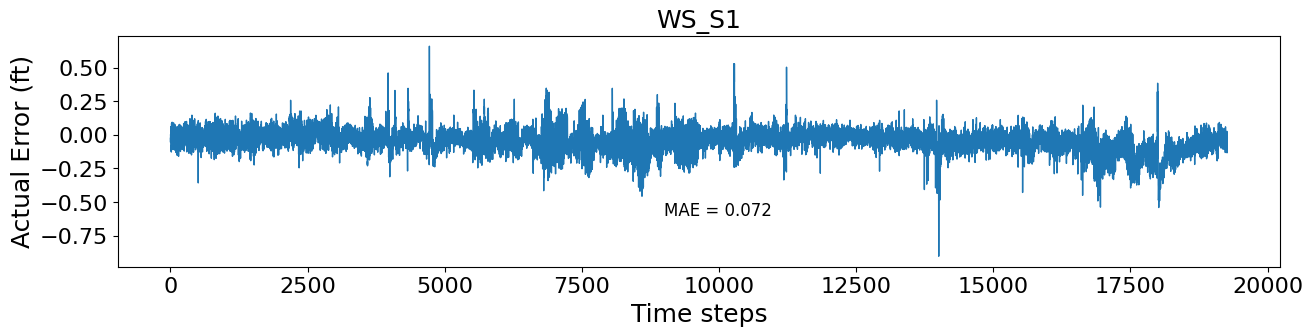

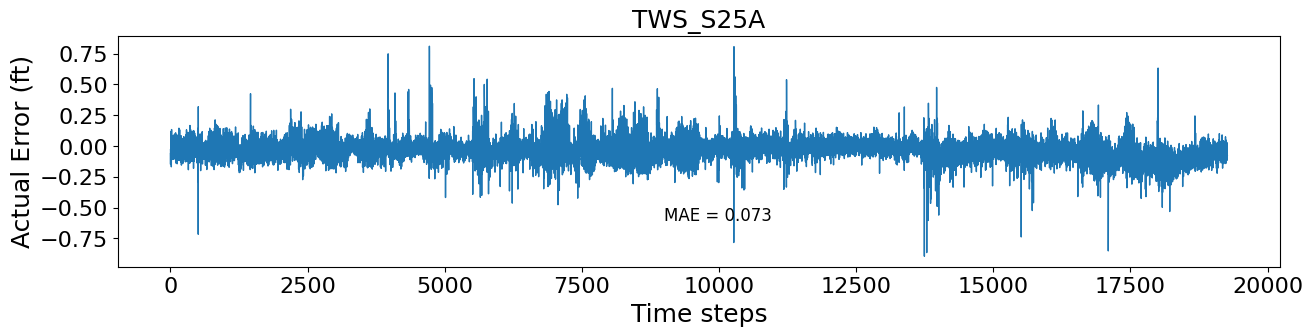

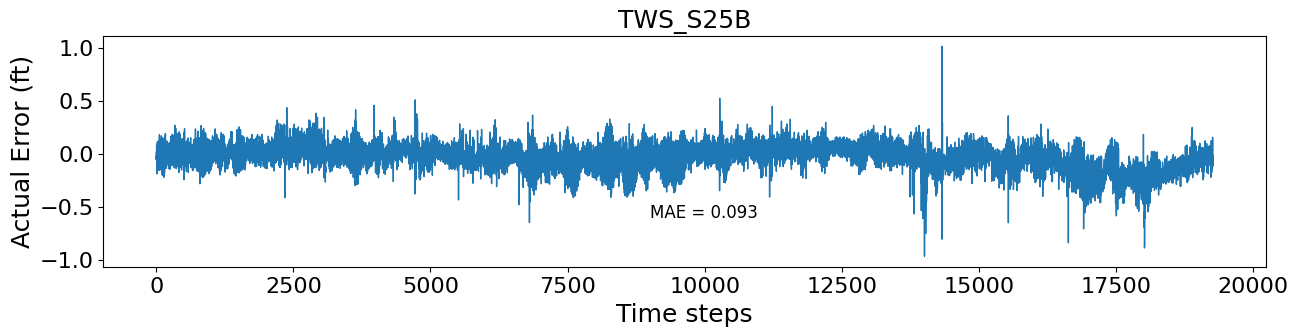

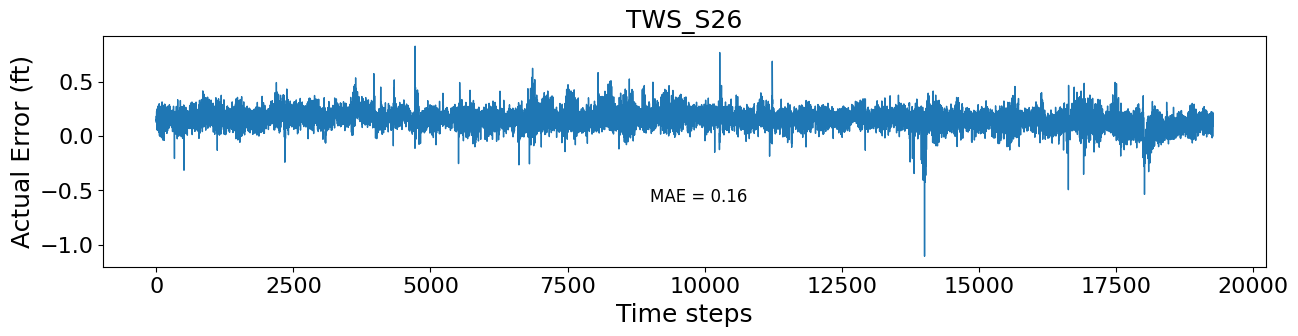

In [20]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [21]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
10
(19268,)
29
(19268,)
60
(19268,)
27


In [22]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
5
(19268,)
16
(19268,)
4
(19268,)
22


In [23]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
5
(19268,)
13
(19268,)
56
(19268,)
5
